### Import libraries

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import butter, filtfilt
import antropy as ant
import spkit as sp
import seaborn as sns
sns.set()
import EntropyHub as En
from sklearn.preprocessing import MinMaxScaler

import warnings
from vmdpy import VMD
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV

### Read and preprocess data

In [2]:
EEG_78_CH2 = pd.read_csv('EEG_78_CH2.csv')
bis_78 = pd.read_csv('bis_78.csv')
B78=bis_78['BIS/BIS']
E78=EEG_78_CH2['BIS/EEG2_WAV']
print ('The shape of EEG signals and BIS for patient 78 is {} and {} '.format(E78.shape,B78.shape) )
print ('The type of EEG signals and BIS for patient 78 is {} and {} '.format(type(E78),type(B78)) )

The shape of EEG signals and BIS for patient 78 is (535191,) and (4180,) 
The type of EEG signals and BIS for patient 78 is <class 'pandas.core.series.Series'> and <class 'pandas.core.series.Series'> 


In [3]:
#checking for missing values

def missing_values(eeg_signal):

    # Check for missing values
    missing_values = np.isnan(eeg_signal)
    length_signals = len(eeg_signal)

    # Count the number of missing values
    num_missing_values = np.sum(missing_values)
    percentage_missing_values = (num_missing_values/length_signals)*100

    # Print the indices and values of missing values
    missing_indices = np.where(missing_values)[0]
    missing_values_list = eeg_signal[missing_indices]

    print("Missing Values:")
    print(f"Total Missing Values: {num_missing_values}")
    print(f"Percentage of Missing Values: {percentage_missing_values} %")  
missing_values(E78)

Missing Values:
Total Missing Values: 167
Percentage of Missing Values: 0.03120381321808476 %


In [4]:
E78_copy = np.copy(E78)

In [5]:
# Handling missing values

def handle_missing_values(signal):
    # Interpolate missing values using linear interpolation
    mask = np.isnan(signal)
    signal[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), signal[~mask])
    return signal
E78_copy=handle_missing_values(E78_copy)

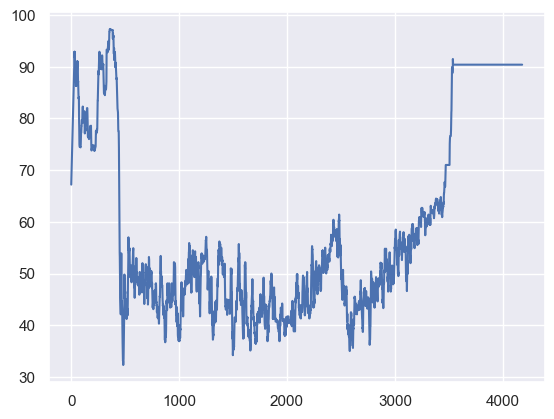

In [6]:
# Replacing the zero values in BIS
from scipy.interpolate import interp1d

def replace_zeroes_with_interpolation(series):
    # Find indices and values of non-zero elements
    non_zero_indices = [i for i, val in enumerate(series) if val != 0]
    non_zero_values = [series[i] for i in non_zero_indices]

    # Create an interpolation function using scipy's interp1d
    interpolation_function = interp1d(non_zero_indices, non_zero_values, kind='linear', bounds_error=False, fill_value="extrapolate")

    # Replace zeroes with interpolated values
    new_series = [interpolation_function(i) if val == 0 else val for i, val in enumerate(series)]

    return new_series

# Test the function
series = B78
new_bis = replace_zeroes_with_interpolation(series)
plt.plot(new_bis)

### Selecting EEG signals

In [6]:
import numpy as np

# Assuming BIS and EEG are numpy arrays
BIS = B78
EEG = E78_copy

# Define the sampling frequency
fs = 128

# Define the indices for BIS range from 200 to 800
bis_start_index = 60
bis_end_index = 3000

# Convert the BIS indices to EEG indices

eeg_start_index = bis_start_index * fs
eeg_end_index = bis_end_index * fs

# Select EEG values for BIS[200:800]
selected_EEG = EEG[eeg_start_index:eeg_end_index]
selected_bis = BIS[bis_start_index:bis_end_index]
selected_bis = np.array(selected_bis)
print(selected_EEG)


[-15.6   -9.35  -6.9  ... -13.25 -15.   -15.35]


### Bandpass filtering

In [7]:
# Define the EEG signal
eeg_signal = selected_EEG # Replace with your actual EEG signal


# Define the filter function
def bandpass_filter(signal, lowcut, highcut, fs, order=3):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

# time in seconds
time = np.arange(len(eeg_signal)) / fs

# Apply bandpass filters to the EEG signal
bpass = bandpass_filter(eeg_signal, 0.01, 63.5, fs=128)


### Variational Mode Decomposition (VMD)

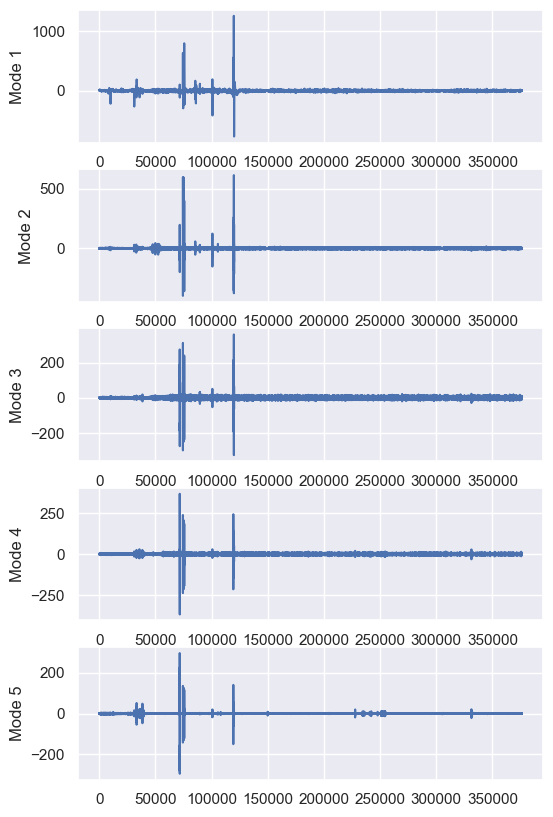

In [8]:


import numpy as np
from vmdpy import VMD

signal = bpass

# Set VMD parameters
alpha = 2000
tau = 0.5
K = 5
DC = 0
init = 1           # initialize omegas uniformly  
tol = 1e-7 

# Run VMD on the signal
modes, spectrum, omega =VMD (signal, alpha, tau, K, DC, init,tol)

#Plot the decomposed modes
import matplotlib.pyplot as plt
fig, axs = plt.subplots(K, 1, figsize=(6, 10))
for i in range(K):
    axs[i].plot(modes[i, :])
    axs[i].set_ylabel(f"Mode {i+1}")
plt.show()

### Windowing and features extraction

Number of BIS: 2885


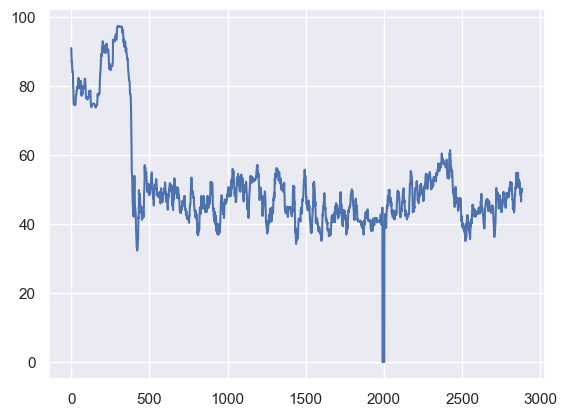

In [9]:
# For BIS

def moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate):
    # Convert window size and overlap from seconds to samples
    window_size = int(window_size_sec * sampling_rate)
    overlap = int(overlap_sec * sampling_rate)

    # Calculate the stride based on the window size and overlap
    stride = window_size - overlap

    # Determine the total number of windows
    num_windows = (len(data) - window_size) // stride + 1

    # Initialize variables
    windows = []

    # Loop over the windows
    for i in range(num_windows):
        window_start = i * stride
        window_end = window_start + window_size
        window = data[window_start:window_end][0]
        windows.append(window)

    return windows

# Example usage
data = selected_bis  # Sample data
window_size_sec = 56.0       # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 1         # Sampling rate in samples per second

# Apply moving sliding window
bis_windows = moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate)

# Print the number of windows and the shape of the first window
print("Number of BIS:", len(bis_windows))
plt.plot(bis_windows)
plt.show()


In [10]:
#### For entropies

def moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate, method):
    # Convert window size and overlap from seconds to samples
    window_size = int(window_size_sec * sampling_rate)
    overlap = int(overlap_sec * sampling_rate)

    # Calculate the stride based on the window size and overlap
    stride = window_size - overlap

    # Determine the total number of windows
    num_windows = (len(data) - window_size) // stride + 1

    # Initialize variables
    
    result = []
    
    # Loop over the windows
    for i in range(num_windows):
        window_start = i * stride
        window_end = window_start + window_size
        window = data[window_start:window_end]
        

        if method == "Permutation entropy":
            # Calculate sample entropy within the window
            permutation_entropy = ant.perm_entropy(window)
            result.append(permutation_entropy)
            
        if method == "Dispersion entropy":
            # Calculate sample entropy within the window
            #Dispersion_entropy, prob =En.DispEn(window,classes=2, scale=3, emb_dim=8, delay=2,return_all=False)
            Dispersion_entropy, prob = sp.dispersion_entropy(window,classes=2, scale=4, emb_dim=3, delay=1,return_all=False)
            result.append(Dispersion_entropy)
            
        if method == "Fuzzy entropy":
            # Calculate sample entropy within the window
            Fuzzy_entropy, prob =En.FuzzEn(window)
            #Dispersion_entropy, prob = sp.dispersion_entropy(window,classes=5, scale=3, emb_dim=5, delay=1,return_all=False)
            result.append(Fuzzy_entropy)
        
         # Detrended Fluctuation
        if method == "detf":
            detf = ant.detrended_fluctuation(window)
            result.append(detf)
            
            
             # Petrosian
        if method == "pet":
            pet = ant.petrosian_fd(window)
            result.append(pet)
            
            
             # hjorth-mobility
        if method == "hm":
            hm = ant.hjorth_params(window)[0]
            result.append(hm)
            
             # hjorth-complex
        if method == "hc":
            hc = ant.hjorth_params(window)[1]
            result.append(hc)
        
    return result


In [11]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]
#data5 = modes[5]

# Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128 


resultsdt_0 = moving_sliding_window(data0, window_size_sec, overlap_sec, sampling_rate, method='detf')
resultsdt_1 = moving_sliding_window(data1, window_size_sec, overlap_sec, sampling_rate, method='detf')
resultsdt_2 = moving_sliding_window(data2, window_size_sec, overlap_sec, sampling_rate, method='detf')
resultsdt_3 = moving_sliding_window(data3, window_size_sec, overlap_sec, sampling_rate, method='detf')
resultsdt_4 = moving_sliding_window(data4, window_size_sec, overlap_sec, sampling_rate, method='detf')
print(f"Number of features:", len(resultsdt_0))

Number of features: 2885


In [12]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]
#data5 = modes[5]

# Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128 


resultspet_0 = moving_sliding_window(data0, window_size_sec, overlap_sec, sampling_rate, method='pet')
resultspet_1 = moving_sliding_window(data1, window_size_sec, overlap_sec, sampling_rate, method='pet')
resultspet_2 = moving_sliding_window(data2, window_size_sec, overlap_sec, sampling_rate, method='pet')
resultspet_3 = moving_sliding_window(data3, window_size_sec, overlap_sec, sampling_rate, method='pet')
resultspet_4 = moving_sliding_window(data4, window_size_sec, overlap_sec, sampling_rate, method='pet')
print(f"Number of features:", len(resultspet_0))

Number of features: 2885


In [13]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]
#data5 = modes[5]

# Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128 


resultshm_0 = moving_sliding_window(data0, window_size_sec, overlap_sec, sampling_rate, method='hm')
resultshm_1 = moving_sliding_window(data1, window_size_sec, overlap_sec, sampling_rate, method='hm')
resultshm_2 = moving_sliding_window(data2, window_size_sec, overlap_sec, sampling_rate, method='hm')
resultshm_3 = moving_sliding_window(data3, window_size_sec, overlap_sec, sampling_rate, method='hm')
resultshm_4 = moving_sliding_window(data4, window_size_sec, overlap_sec, sampling_rate, method='hm')
print(f"Number of features:", len(resultshm_0))

Number of features: 2885


In [14]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]
#data5 = modes[5]

# Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128 


resultshc_0 = moving_sliding_window(data0, window_size_sec, overlap_sec, sampling_rate, method='hc')
resultshc_1 = moving_sliding_window(data1, window_size_sec, overlap_sec, sampling_rate, method='hc')
resultshc_2 = moving_sliding_window(data2, window_size_sec, overlap_sec, sampling_rate, method='hc')
resultshc_3 = moving_sliding_window(data3, window_size_sec, overlap_sec, sampling_rate, method='hc')
resultshc_4 = moving_sliding_window(data4, window_size_sec, overlap_sec, sampling_rate, method='hc')
print(f"Number of features:", len(resultshc_0))

Number of features: 2885


In [15]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]

# Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128        # Sampling rate in samples per second


# Apply moving sliding window and calculate sample entropies
resultsp_0 = moving_sliding_window(data0, window_size_sec, overlap_sec, sampling_rate, method='Permutation entropy')
resultsp_1 = moving_sliding_window(data1, window_size_sec, overlap_sec, sampling_rate, method='Permutation entropy')
resultsp_2 = moving_sliding_window(data2, window_size_sec, overlap_sec, sampling_rate, method='Permutation entropy')
resultsp_3 = moving_sliding_window(data3, window_size_sec, overlap_sec, sampling_rate, method='Permutation entropy')
resultsp_4 = moving_sliding_window(data4, window_size_sec, overlap_sec, sampling_rate, method='Permutation entropy')

print(f"Number of features:", len(resultsp_0))


Number of features: 2885


In [16]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]

# Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128        # Sampling rate in samples per second


# Apply moving sliding window and calculate sample entropies
resultsd_0 = moving_sliding_window(data0, window_size_sec, overlap_sec, sampling_rate, method='Dispersion entropy')
resultsd_1 = moving_sliding_window(data1, window_size_sec, overlap_sec, sampling_rate, method='Dispersion entropy')
resultsd_2 = moving_sliding_window(data2, window_size_sec, overlap_sec, sampling_rate, method='Dispersion entropy')
resultsd_3 = moving_sliding_window(data3, window_size_sec, overlap_sec, sampling_rate, method='Dispersion entropy')
resultsd_4 = moving_sliding_window(data4, window_size_sec, overlap_sec, sampling_rate, method='Dispersion entropy')
print(f"Number of features:", len(resultsd_0))


Number of features: 2885


### Create Dataframe for each feature and find the correlation


In [17]:
# detf

df_detf = pd.DataFrame({'detf_mode0': resultsdt_0, 'detf_mode1': resultsdt_1, 'detf_mode2': resultsdt_2, 'detf_mode3': resultsdt_3, 'detf_mode4': resultsdt_4})

df_detf['BIS']=bis_windows
#df_detf


In [18]:
# pet

df_pet = pd.DataFrame({'pet_mode0': resultspet_0, 'pet_mode1': resultspet_1, 'pet_mode2': resultspet_2, 'pet_mode3': resultspet_3, 'pet_mode4': resultspet_4})

df_pet['BIS']=bis_windows
#df_pet



In [19]:
# hm

df_hm = pd.DataFrame({'hm_mode0': resultshm_0, 'hm_mode1': resultshm_1, 'hm_mode2': resultshm_2, 'hm_mode3': resultshm_3, 'hm_mode4': resultshm_4})

df_hm['BIS']=bis_windows
#df_hm


In [20]:
# hc

df_hc = pd.DataFrame({'hc_mode0': resultshc_0, 'hc_mode1': resultshc_1, 'hc_mode2': resultshc_2, 'hc_mode3': resultshc_3, 'hc_mode4': resultshc_4})

df_hc['BIS']=bis_windows
#df_hc


In [21]:
# Permutation entropy

df_perm = pd.DataFrame({'Perment_mode0': resultsp_0, 'Perment_mode1': resultsp_1, 'Perment_mode2': resultsp_2, 'Perment_mode3': resultsp_3, 'Perment_mode4': resultsp_4})

df_perm['BIS']=bis_windows
#df_perm

In [22]:
# Dispersion entropy

df_disp = pd.DataFrame({'Disp_mode0': resultsd_0, 'Disp_mode1': resultsd_1, 'Disp_mode2': resultsd_2, 'Disp_mode3': resultsd_3, 'Disp_mode4': resultsd_4})

df_disp['BIS']=bis_windows
#df_disp

### Save the extracted data in csv

In [23]:
df_detf.to_csv('detf_78' , index=False)
df_hm.to_csv('hm_78', index=False)
df_hc.to_csv('hc_78', index=False)
df_perm.to_csv('perm_78', index=False)
df_pet.to_csv('pet_78', index=False)
df_disp.to_csv('disp_78', index=False)

In [27]:
metrics = {}
def plot_regression(data, column):
    
    global metrics
    
    X = data[column].values.reshape(-1, 1)
    #X = X[:, np.newaxis]
    y = data['BIS']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

    # Perform regression
    reg = LinearRegression(n_jobs=-1).fit(X_train, y_train)
    
    # Predictions
    y_predicted = reg.predict(X_test)
    
    # Show the score and r2
    #mse = mean_squared_error(y, y_predicted)
    r2 = r2_score(y_test, y_predicted)
    
    # keep track of metrics
    
    #metrics["{}_mse".format(column)] = mse
    metrics["{}_r2".format(column)] = r2
    
    
    
    # Plot the graph#
    plt.figure(figsize=(8,6))
    plt.scatter(data[column], data['BIS'], label="data", c="blue")
    plt.plot(X_test, y_predicted, label="Regression", c="red")
    plt.xlabel(column)
    plt.ylabel('BIS')
    plt.legend(loc="upper left")
    plt.show()

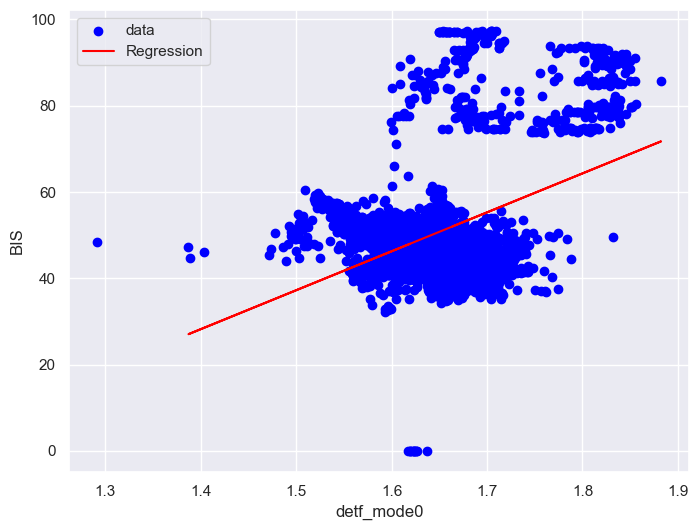

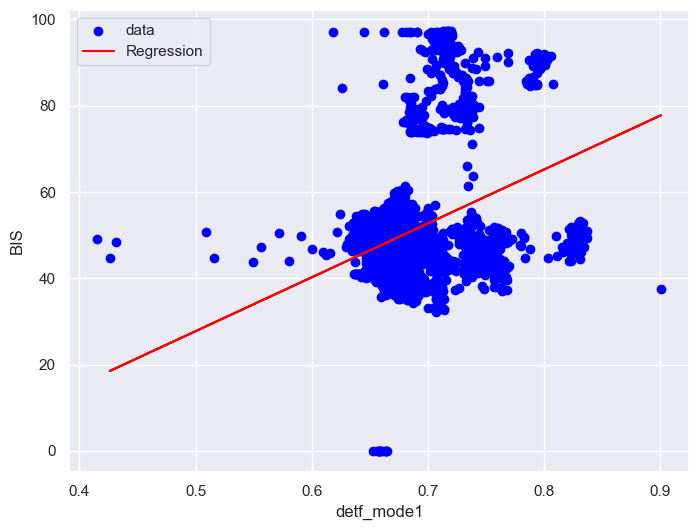

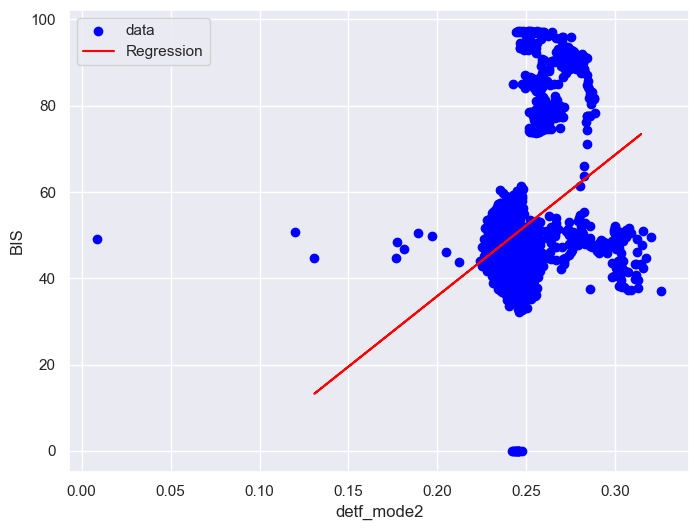

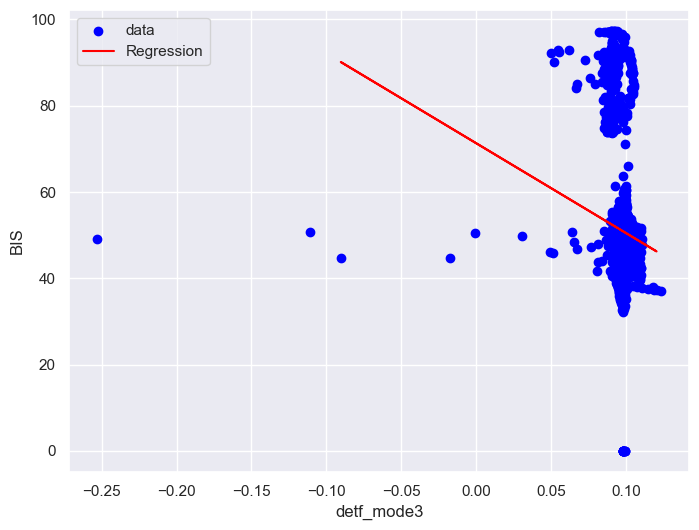

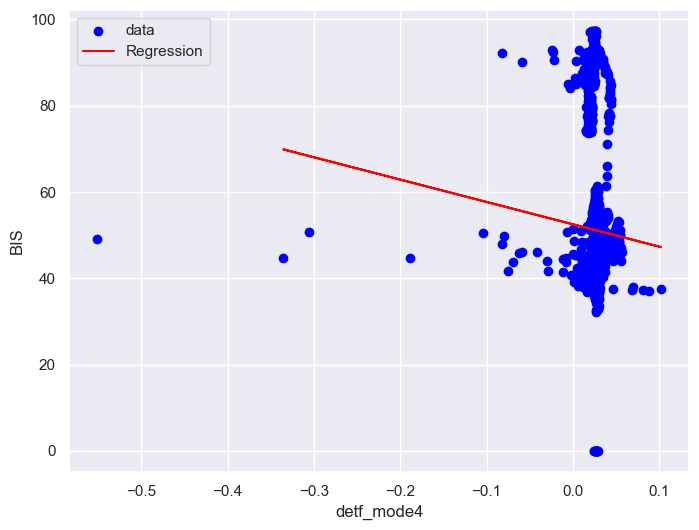

In [28]:
for column in df_detf.columns:
    if column == "BIS":
        continue
        
    plot_regression(df_detf, column)

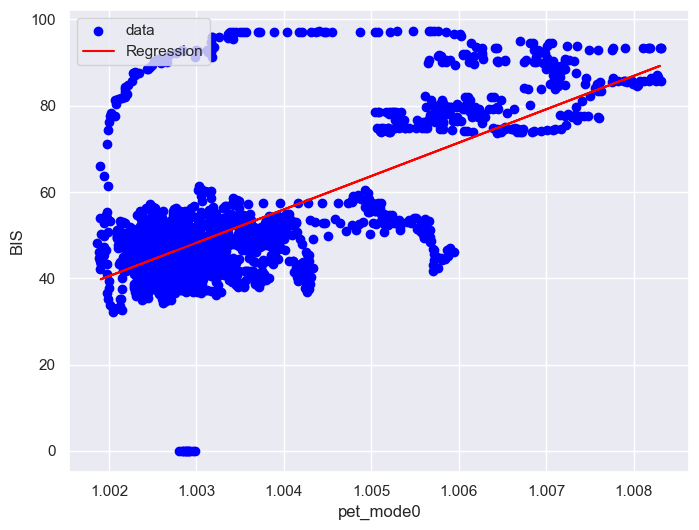

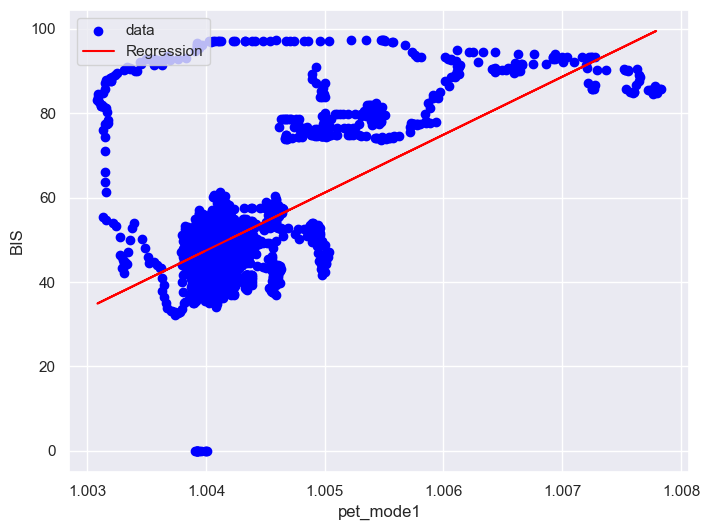

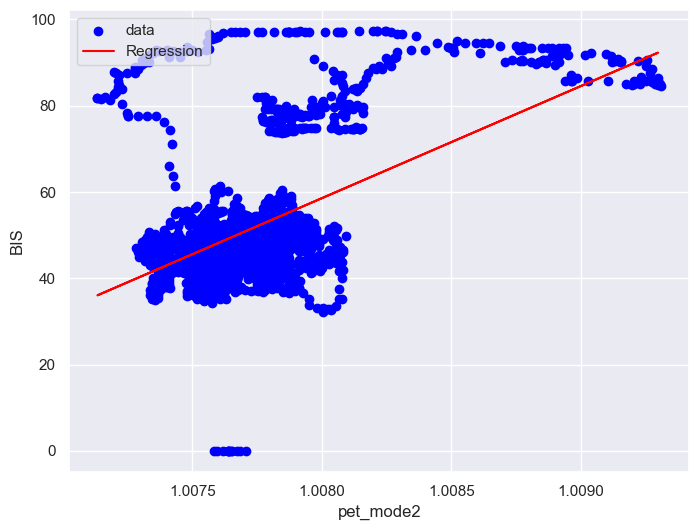

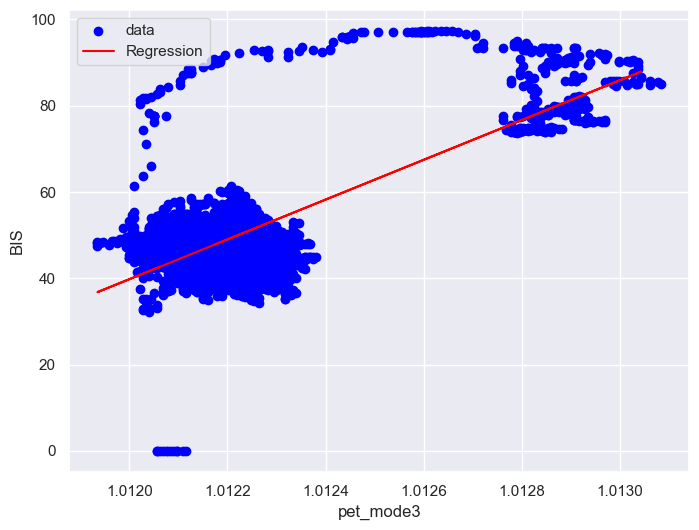

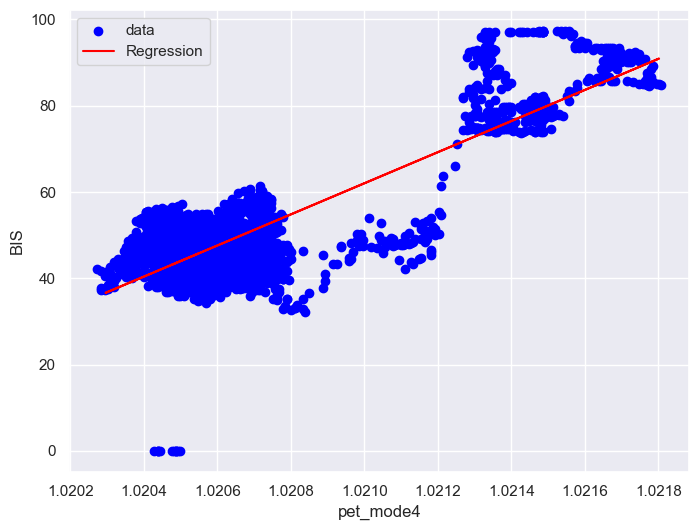

In [30]:
for column in df_pet.columns:
    if column == "BIS":
        continue
        
    plot_regression(df_pet, column)

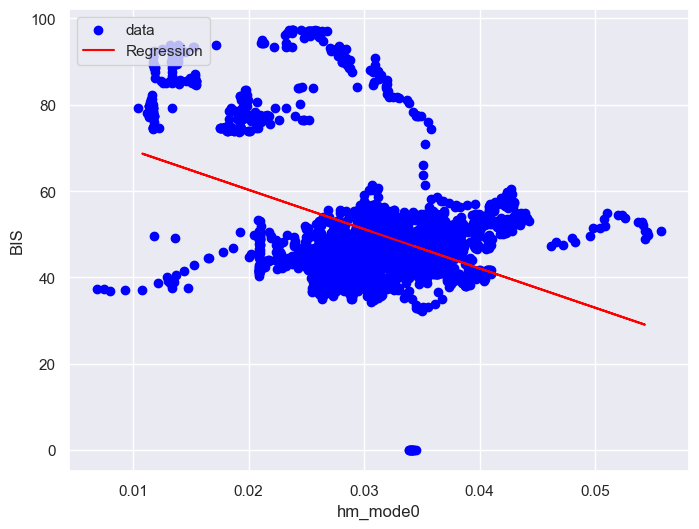

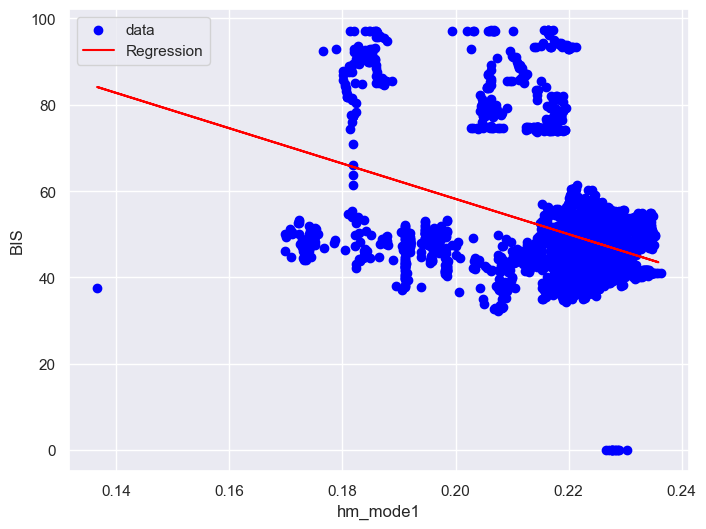

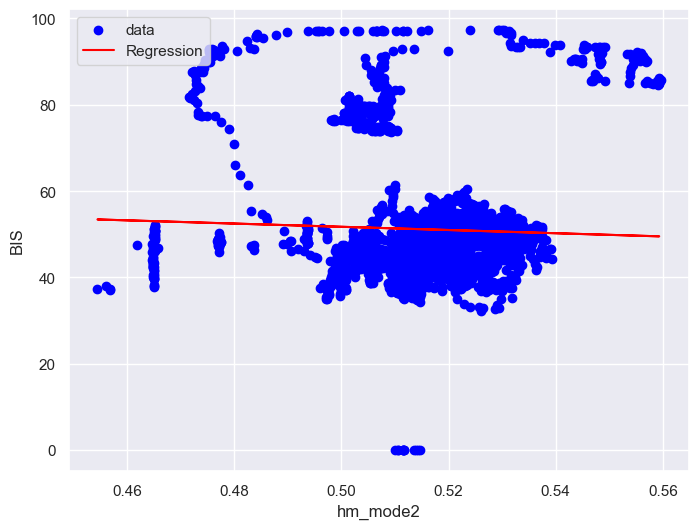

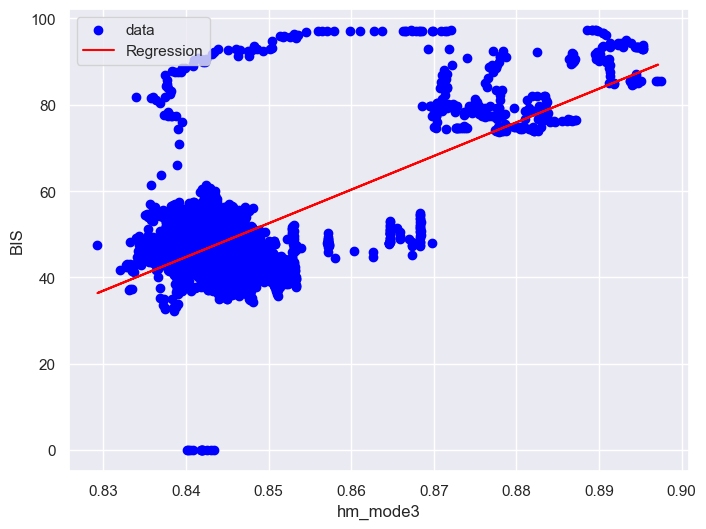

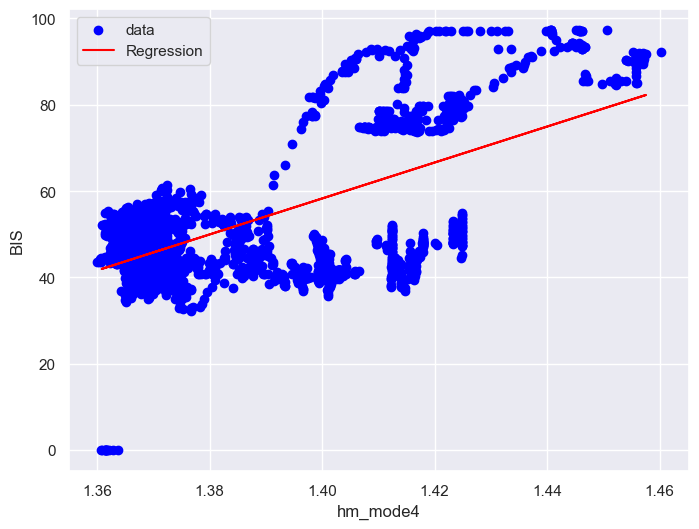

In [32]:
for column in df_hm.columns:
    if column == "BIS":
        continue
        
    plot_regression(df_hm, column)

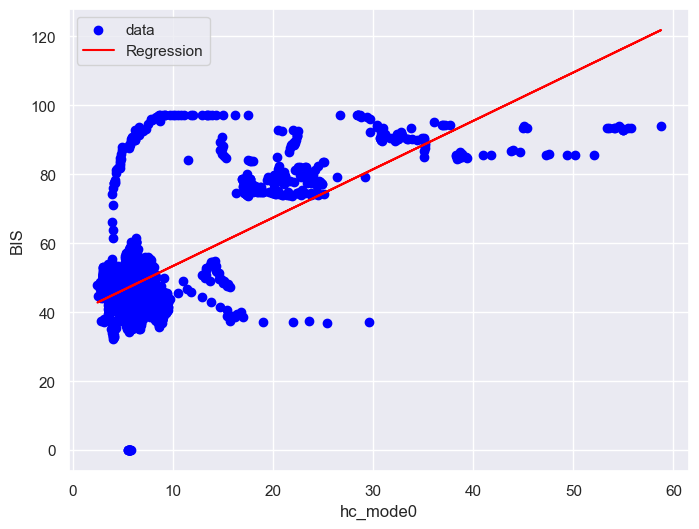

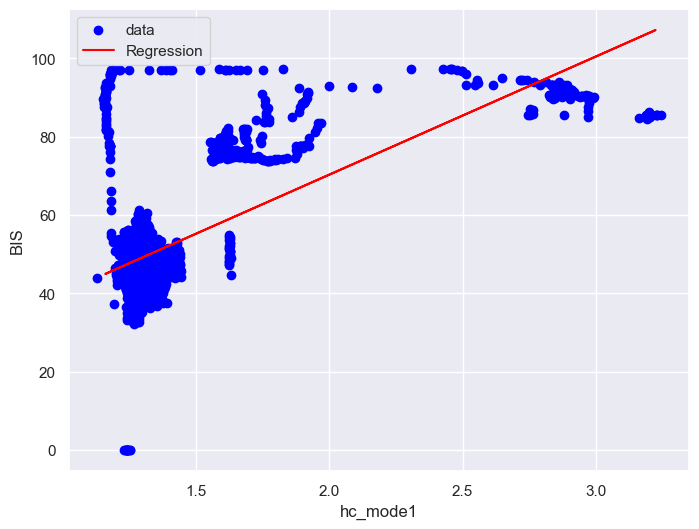

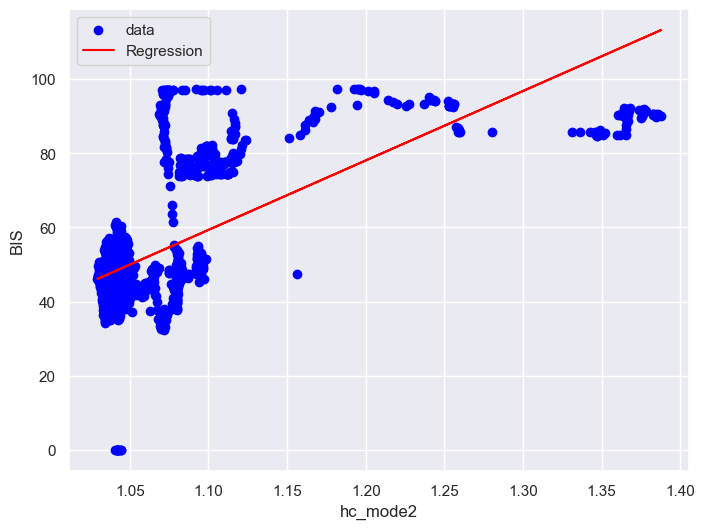

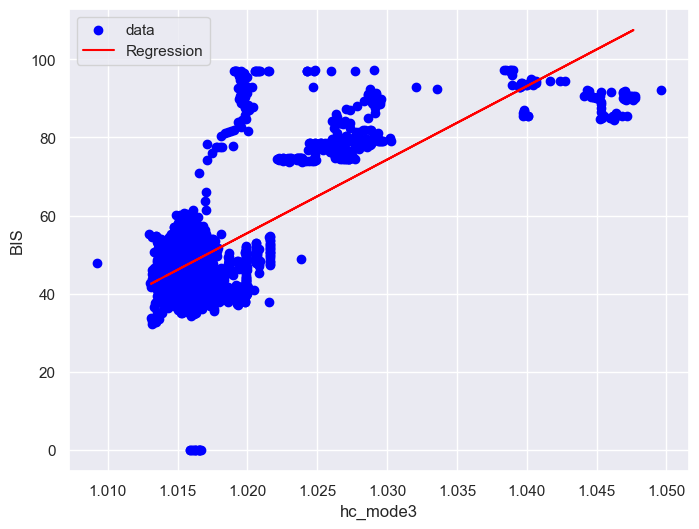

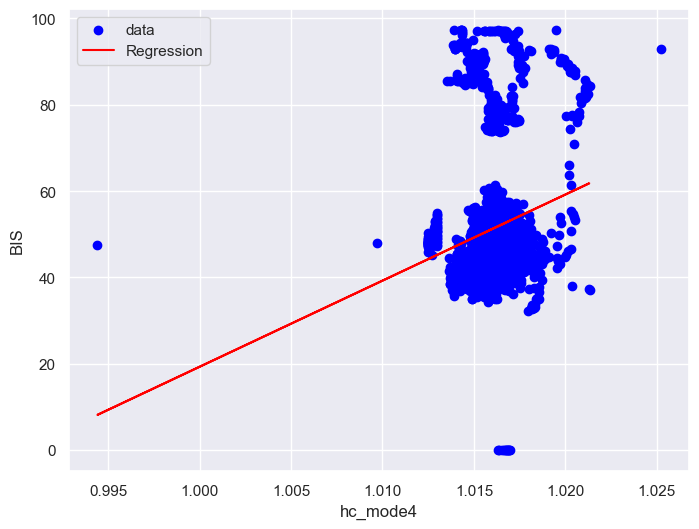

In [33]:
for column in df_hc.columns:
    if column == "BIS":
        continue
        
    plot_regression(df_hc, column)

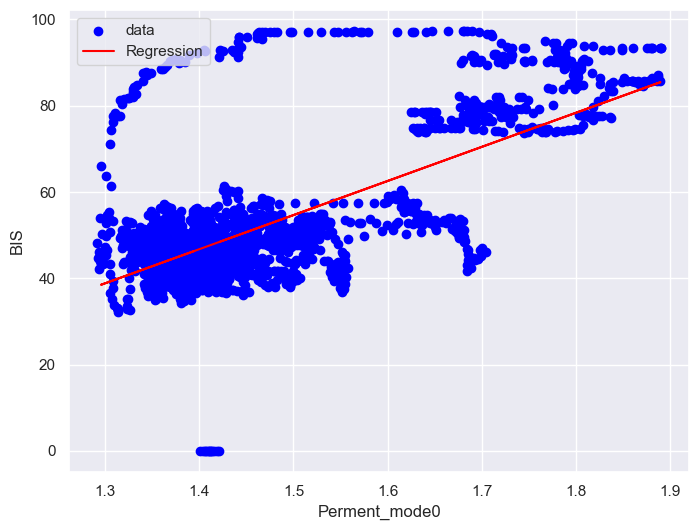

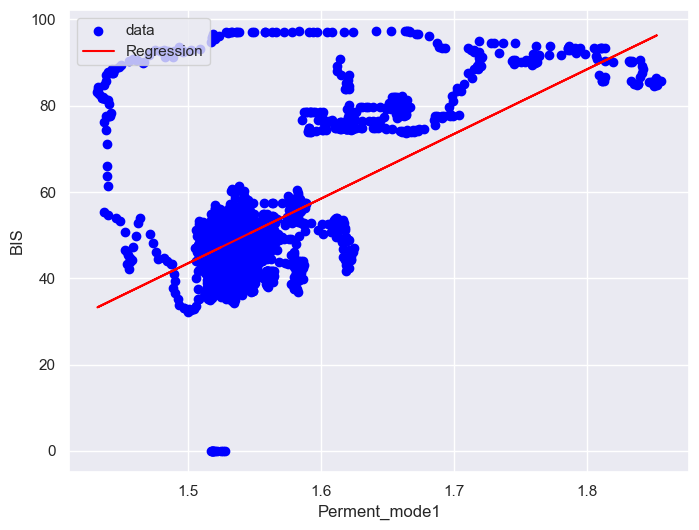

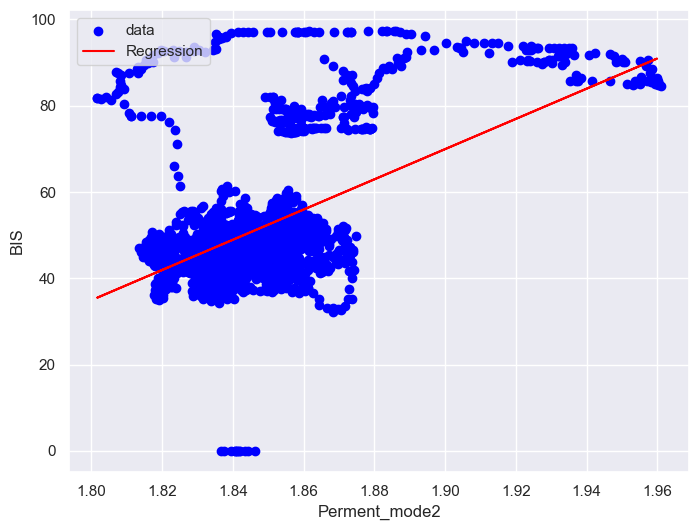

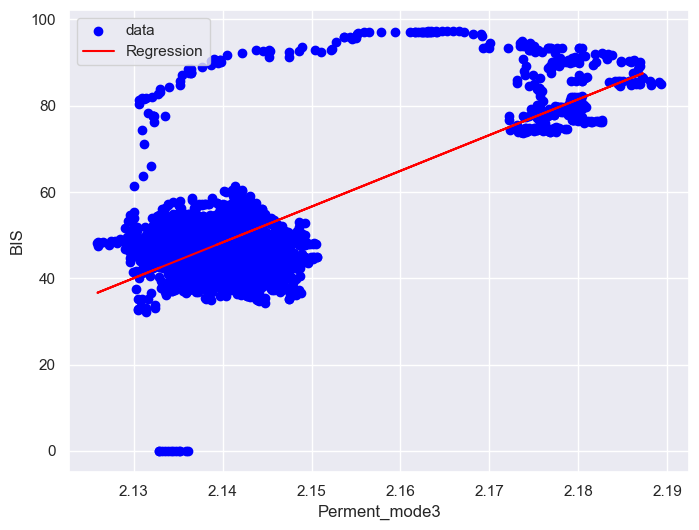

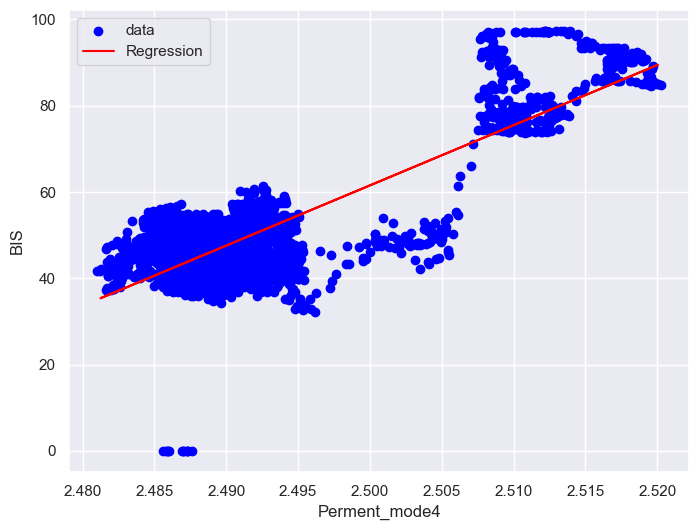

In [34]:
for column in df_perm.columns:
    if column == "BIS":
        continue
        
    plot_regression(df_perm, column)
    
# Metrics
#pd.DataFrame({"Metrics": [key for key in metrics.keys()], "Values": [value for value in metrics.values()]})

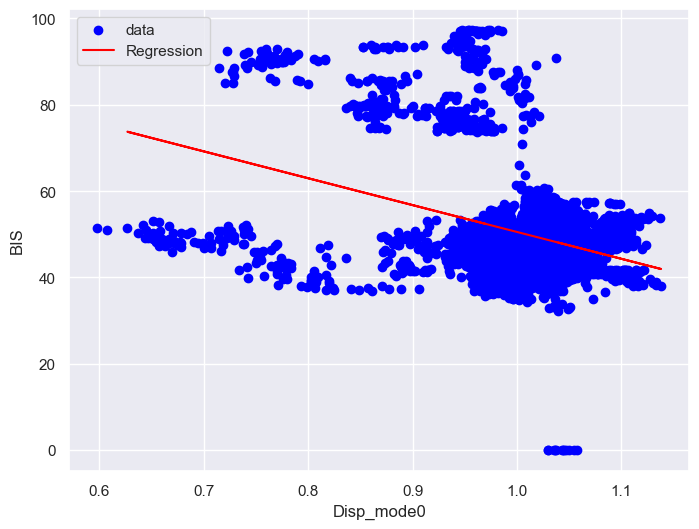

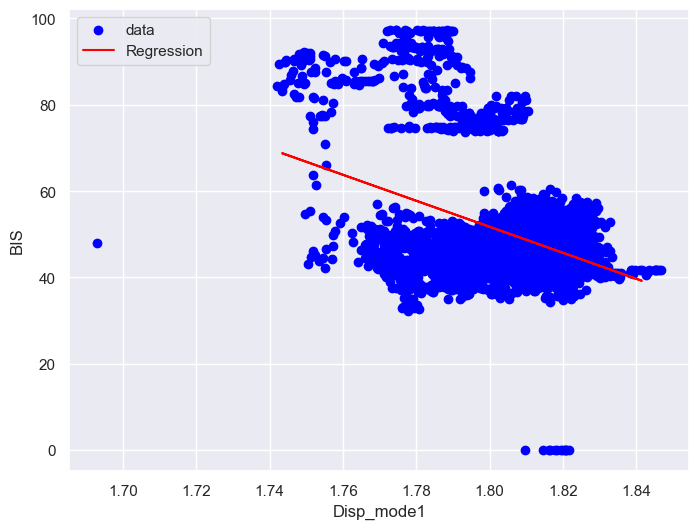

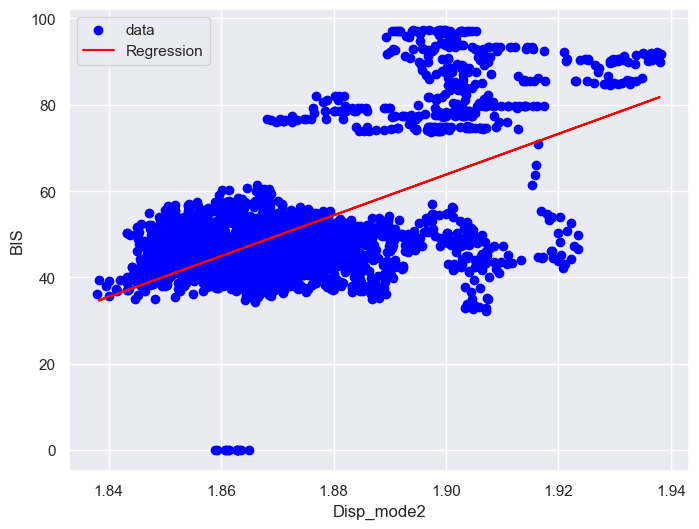

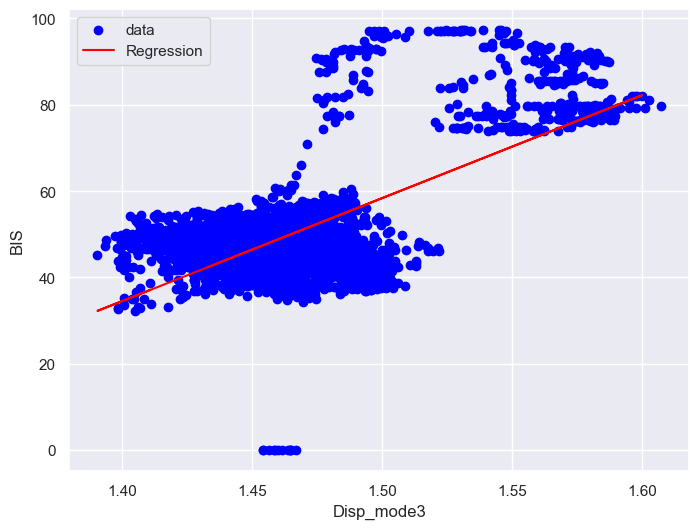

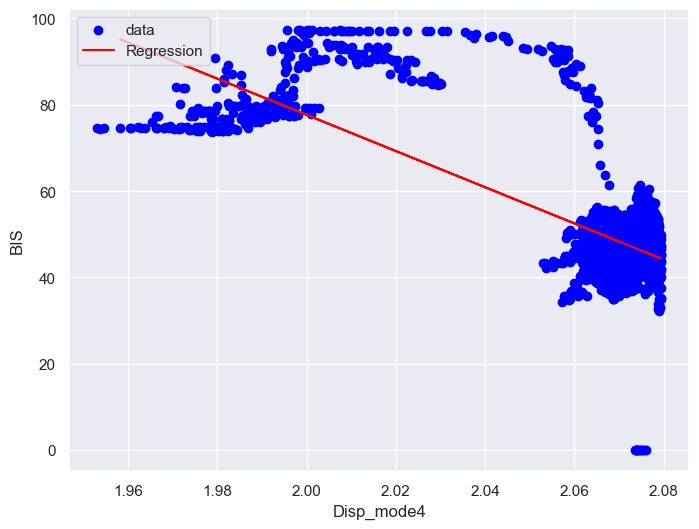

In [35]:
for column in df_disp.columns:
    if column == "BIS":
        continue
        
    plot_regression(df_disp, column)
    
# Metrics
#pd.DataFrame({"Metrics": [key for key in metrics.keys()], "Values": [value for value in metrics.values()]})

In [36]:
# Metrics
total=pd.DataFrame({"Metrics": [key for key in metrics.keys()], "Values": [value*100 for value in metrics.values()]})


In [37]:
sort_total=total.sort_values('Values', ascending=False)
sort_total

,Metrics,Values
9,pet_mode4_r2,70.329059
24,Perment_mode4_r2,68.595439
29,Disp_mode4_r2,60.572056
18,hc_mode3_r2,59.083945
8,pet_mode3_r2,58.145819
23,Perment_mode3_r2,58.053575
15,hc_mode0_r2,54.807503
5,pet_mode0_r2,53.757276
13,hm_mode3_r2,53.544080
20,Perment_mode0_r2,52.085338


In [43]:
gud=pd.DataFrame({'Perment_mode0_r2':resultsp_0, 'Perment_mode1_r2':resultsp_1, 'Perment_mode2_r2':resultsp_2, 'Perment_mode3_r2':resultsp_3, 'Perment_mode4_r2':resultsp_4,
                 'detf_mode0_r2':resultsdt_0, 'detf_mode1_r2':resultsdt_1, 'detf_mode2_r2':resultsdt_2, 'detf_mode3_r2':resultsdt_3, 'detf_mode4_r2':resultsdt_4,
                 'pet_mode0_r2':resultspet_0,'pet_mode1_r2':resultspet_1, 'pet_mode2_r2':resultspet_2, 'pet_mode3_r2':resultspet_3, 'pet_mode4_r2':resultspet_4,
                 'hm_mode0_r2':resultshm_0, 'hm_mode1_r2':resultshm_1, 'hm_mode2_r2':resultshm_2, 'hm_mode3_r2':resultshm_3, 'hm_mode4_r2':resultshm_4,
                 'hc_mode0_r2':resultshc_0, 'hc_mode1_r2':resultshc_1, 'hc_mode2_r2':resultshc_2, 'hc_mode3_r2':resultshc_3, 'hc_mode4_r2':resultshc_4,
                  'disp_mode0_r2':resultsd_0, 'disp_mode1_r2':resultsd_1, 'disp_mode2_r2':resultsd_2, 'disp_mode3_r2':resultsd_3, 'disp_mode4_r2':resultsd_4 
                 })

In [33]:
#combine=buk[['Perment_mode3', 'detf_mode1_r2', 'pet_mode3_r2', 'hm_mode2_r2', 'hc_mode1_r2', 'Disp_mode4_r2']]
gud=pd.DataFrame({'Perment_mode0_r2':resultsp_0, 'Perment_mode1_r2':resultsp_1, 'Perment_mode2_r2':resultsp_2, 'Perment_mode3_r2':resultsp_3, 'Perment_mode4_r2':resultsp_4,
                 'detf_mode0_r2':resultsdt_0, 'detf_mode1_r2':resultsdt_1, 'detf_mode2_r2':resultsdt_2, 'detf_mode3_r2':resultsdt_3, 'detf_mode4_r2':resultsdt_4,
  
                  'pet_mode0_r2':resultspet_0,'pet_mode1_r2':resultspet_1, 'pet_mode2_r2':resultspet_2, 'pet_mode3_r2':resultspet_3, 'pet_mode4_r2':resultspet_4,
                 'hm_mode0_r2':resultshm_0, 'hm_mode1_r2':resultshm_1, 'hm_mode2_r2':resultshm_2, 'hm_mode3_r2':resultshm_3, 'hm_mode4_r2':resultshm_4,
                 'hc_mode0_r2':resultshc_0, 'hc_mode1_r2':resultshc_1, 'hc_mode2_r2':resultshc_2, 'hc_mode3_r2':resultshc_3, 'hc_mode4_r2':resultshc_4,
                  'disp_mode0_r2':resultsd_0, 'disp_mode1_r2':resultsd_1, 'disp_mode2_r2':resultsd_2, 'disp_mode3_r2':resultsd_3, 'disp_mode4_r2':resultsd_4 
                 })


gud=gud[['hc_mode1_r2','disp_mode4_r2', 'pet_mode4_r2']]
new_y=df_hm['BIS']


mm = LinearRegression(n_jobs=-1).fit(gud, new_y)
    
# Predictions
y_pre = mm.predict(gud)
    
# Show the score and r2
mse = mean_squared_error(new_y, y_pre)
r2 = r2_score(new_y, y_pre)
    

print("Multiple regression model Slope = %s, and intercept =%s"%(mm.coef_,mm.intercept_))
print('R_Squared_value for the multiple regression model: ', r2*100)
print('MSE: ', mse)

Multiple regression model Slope = [ 4.49420096e+00 -1.24110699e+02  2.52663204e+04], and intercept =-25488.239325878712
R_Squared_value for the multiple regression model:  72.38939102325389
MSE:  57.639032882271096


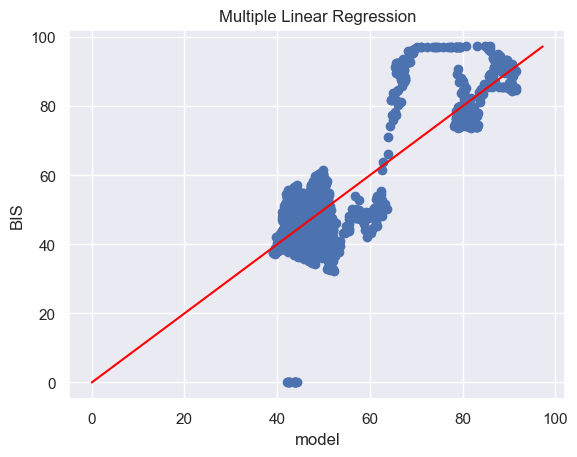

In [34]:
x1=gud['hc_mode1_r2']
x2=gud['disp_mode4_r2']
x3=gud['pet_mode4_r2']

y_plot =mm.coef_[0]*x1+mm.coef_[1]*x2+mm.coef_[2]*x3 +mm.intercept_

plt.scatter(y_plot, new_y)
plt.plot( [new_y.min(), new_y.max()], [new_y.min(), new_y.max()], label="Regression", c="red")

plt.title('Multiple Linear Regression')
plt.ylabel('BIS')
plt.xlabel('model')
plt.show()

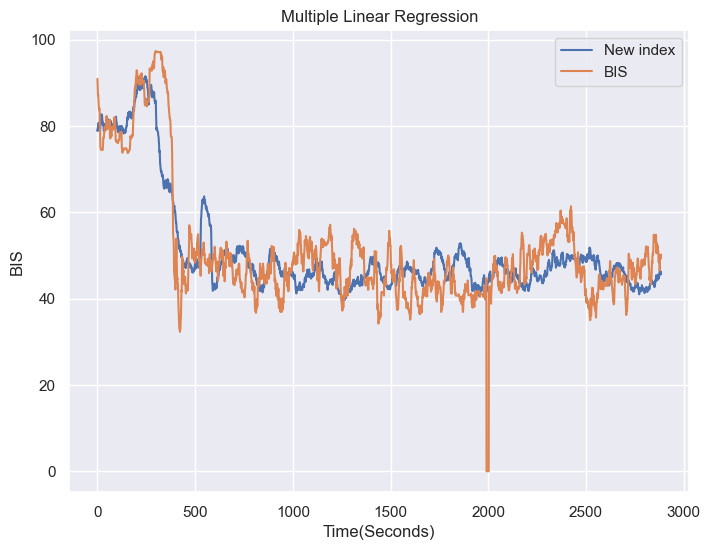

In [35]:
plt.figure(figsize=(8,6))
plt.plot(y_plot, label='New index')
plt.plot(df_disp['BIS'],label ="BIS")
plt.title('Multiple Linear Regression')
plt.ylabel('BIS')
plt.xlabel('Time(Seconds)')
plt.legend(loc="upper right")
plt.show()

pet3=44.9 +detf1=48.411
pet3=44.9 +hm1=48.8066 + 'disp_mode4_r2'=52.11
pet3=44.9 +hc1=48.409 + 'disp_mode4_r2'=52.28
pet3=44.9 +disp1=48.066
pet3=44.9 +disp4=48.09

'hc_mode1_r2','disp_mode4_r2', 'pet_mode1_r2'=55.71
'hc_mode1_r2','disp_mode4_r2', 'detf_mode3_r2'=52.95

'hc_mode1_r2','disp_mode4_r2', 'Perment_mode1_r2'=55.76


52.31 = 'Perment_mode4', 'hc_mode1_r2', 'Disp_mode4_r2'

In [36]:
#combine=buk[['Perment_mode3', 'detf_mode1_r2', 'pet_mode3_r2', 'hm_mode2_r2', 'hc_mode1_r2', 'Disp_mode4_r2']]
gud=pd.DataFrame({'Perment_mode0_r2':resultsp_0, 'Perment_mode1_r2':resultsp_1, 'Perment_mode2_r2':resultsp_2, 'Perment_mode3_r2':resultsp_3, 'Perment_mode4_r2':resultsp_4,
                 'detf_mode0_r2':resultsdt_0, 'detf_mode1_r2':resultsdt_1, 'detf_mode2_r2':resultsdt_2, 'detf_mode3_r2':resultsdt_3, 'detf_mode4_r2':resultsdt_4,
  
                  'pet_mode0_r2':resultspet_0,'pet_mode1_r2':resultspet_1, 'pet_mode2_r2':resultspet_2, 'pet_mode3_r2':resultspet_3, 'pet_mode4_r2':resultspet_4,
                 'hm_mode0_r2':resultshm_0, 'hm_mode1_r2':resultshm_1, 'hm_mode2_r2':resultshm_2, 'hm_mode3_r2':resultshm_3, 'hm_mode4_r2':resultshm_4,
                 'hc_mode0_r2':resultshc_0, 'hc_mode1_r2':resultshc_1, 'hc_mode2_r2':resultshc_2, 'hc_mode3_r2':resultshc_3, 'hc_mode4_r2':resultshc_4,
                  'disp_mode0_r2':resultsd_0, 'disp_mode1_r2':resultsd_1, 'disp_mode2_r2':resultsd_2, 'disp_mode3_r2':resultsd_3, 'disp_mode4_r2':resultsd_4 
                 })


gud=gud[['disp_mode4_r2', 'hm_mode3_r2', 'Perment_mode4_r2']]
new_y=df_hm['BIS']


mm = LinearRegression(n_jobs=-1).fit(gud, new_y)
    
# Predictions
y_pre = mm.predict(gud)
    
# Show the score and r2
mse = mean_squared_error(new_y, y_pre)
r2 = r2_score(new_y, y_pre)
    

print("Multiple regression model Slope = %s, and intercept =%s"%(mm.coef_,mm.intercept_))
print('R_Squared_value for the multiple regression model: ', r2*100)
print(mse)

Multiple regression model Slope = [-178.20673431  -93.57134695 1074.10421937], and intercept =-2179.0735270380246
R_Squared_value for the multiple regression model:  71.08640992945638
60.359094948762426


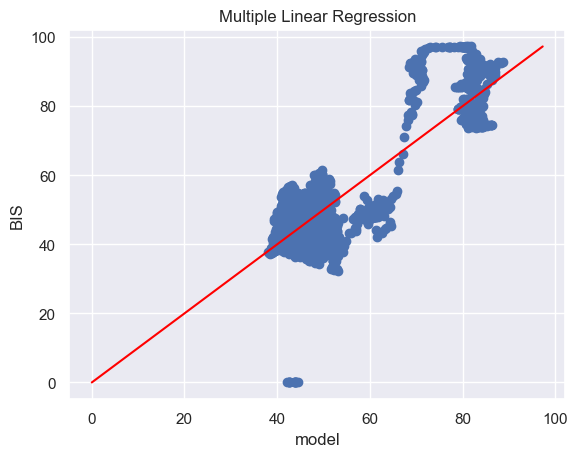

In [37]:
#x1=gud['pet_mode4_r2']
x2=gud['disp_mode4_r2']
x3=gud['hm_mode3_r2']
#x4=gud['detf_mode0_r2']
x5=gud['Perment_mode4_r2']



y_plot =mm.coef_[0]*x2+mm.coef_[1]*x3+mm.coef_[2]*x5 +mm.intercept_

plt.scatter(y_plot, new_y)
plt.plot( [new_y.min(), new_y.max()], [new_y.min(), new_y.max()], label="Regression", c="red")

plt.title('Multiple Linear Regression')
plt.ylabel('BIS')
plt.xlabel('model')
plt.show()

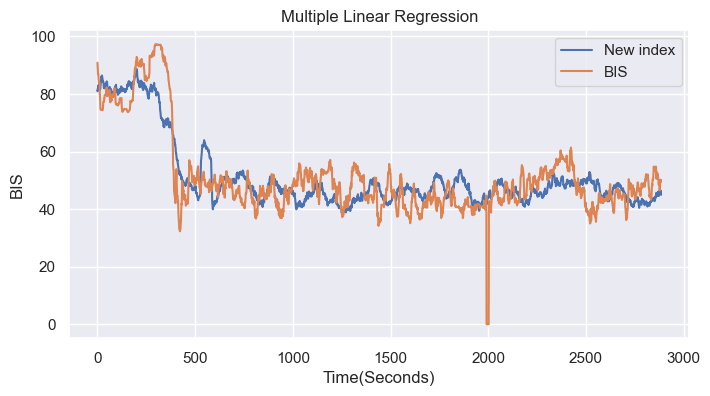

In [38]:
plt.figure(figsize=(8,4))
plt.plot(y_plot, label='New index')
plt.plot(df_disp['BIS'],label ="BIS")
plt.title('Multiple Linear Regression')
plt.ylabel('BIS')
plt.xlabel('Time(Seconds)')
plt.legend(loc="upper right")
plt.show()

In [ ]:
# Polynomial

In [ ]:
#combine=buk[['Perment_mode3', 'detf_mode1_r2', 'pet_mode3_r2', 'hm_mode2_r2', 'hc_mode1_r2', 'Disp_mode4_r2']]
gud=pd.DataFrame({'Perment_mode0_r2':resultsp_0, 'Perment_mode1_r2':resultsp_1, 'Perment_mode2_r2':resultsp_2, 'Perment_mode3_r2':resultsp_3, 'Perment_mode4_r2':resultsp_4,
                 'detf_mode0_r2':resultsdt_0, 'detf_mode1_r2':resultsdt_1, 'detf_mode2_r2':resultsdt_2, 'detf_mode3_r2':resultsdt_3, 'detf_mode4_r2':resultsdt_4,
  
                  'pet_mode0_r2':resultspet_0,'pet_mode1_r2':resultspet_1, 'pet_mode2_r2':resultspet_2, 'pet_mode3_r2':resultspet_3, 'pet_mode4_r2':resultspet_4,
                 'hm_mode0_r2':resultshm_0, 'hm_mode1_r2':resultshm_1, 'hm_mode2_r2':resultshm_2, 'hm_mode3_r2':resultshm_3, 'hm_mode4_r2':resultshm_4,
                 'hc_mode0_r2':resultshc_0, 'hc_mode1_r2':resultshc_1, 'hc_mode2_r2':resultshc_2, 'hc_mode3_r2':resultshc_3, 'hc_mode4_r2':resultshc_4,
                  'disp_mode0_r2':resultsd_0, 'disp_mode1_r2':resultsd_1, 'disp_mode2_r2':resultsd_2, 'disp_mode3_r2':resultsd_3, 'disp_mode4_r2':resultsd_4 
                 })


gud=gud[['hc_mode1_r2','disp_mode4_r2', 'pet_mode4_r2']]
new_y=df_hm['BIS']

In [39]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

# Sample data for demonstration (replace this with your actual data)


# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(gud, new_y, test_size=0.2, random_state=42)

# Polynomial Features transformation
poly = PolynomialFeatures(degree=2)  # You can set the degree as desired (e.g., 2, 3, etc.)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Multiple Linear Regression with Polynomial Features
linear_model = LinearRegression()
linear_model.fit(X_train_poly, y_train)

# Make predictions on the test set using the model with polynomial features
y_pred = linear_model.predict(X_test_poly)

# Model evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE) with Polynomial Features:", mse)
print("R-squared (R2) with Polynomial Features:", r2)


Mean Squared Error (MSE) with Polynomial Features: 39.53982105759122
R-squared (R2) with Polynomial Features: 0.8113005766118637


In [41]:
# ploynomial

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

# Sample data for demonstration (replace this with your actual data)


# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(gud, new_y, test_size=0.2, random_state=42)

# Create a Pipeline for polynomial features and linear regression
pipeline = Pipeline([
    ('poly', PolynomialFeatures()),
    ('regressor', LinearRegression())
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'poly__degree': [2,4, 6],  # The degree of polynomial features
    'regressor__fit_intercept': [True, False],  # Whether to fit the intercept
    #'regressor__normalize': [True, False]  # Whether to normalize the features
}

# Create a GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring='neg_mean_squared_error')

# Perform the grid search to find the best hyperparameters
grid_search.fit(X_train, y_train)

# Get the best model with the best hyperparameters
best_model = grid_search.best_estimator_

# Make predictions on the test set using the best model
y_pred = best_model.predict(X_test)

# Model evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Best Model with Polynomial Features:", best_model)
print("Mean Squared Error (MSE) with Polynomial Features:", mse)
print("R-squared (R2) with Polynomial Features:", r2)


Best Model with Polynomial Features: Pipeline(steps=[('poly', PolynomialFeatures(degree=4)),
                ('regressor', LinearRegression(fit_intercept=False))])
Mean Squared Error (MSE) with Polynomial Features: 27.204223978513884
R-squared (R2) with Polynomial Features: 0.8701708495091502


In [51]:
new_in = best_model.predict(gud)

# Normalize the new index to the desired range (e.g., [0, 100]) using MinMaxScaler
scaler = MinMaxScaler(feature_range=(40, 90))
new_index_normalized = scaler.fit_transform(new_in.reshape(-1, 1)).flatten()

# Display the normalized new index for the first few data points
print("Normalized New Index:")
print(new_index_normalized[:5])

Normalized New Index:
[70.5868235  71.8539431  72.50644743 72.96670163 72.47303155]


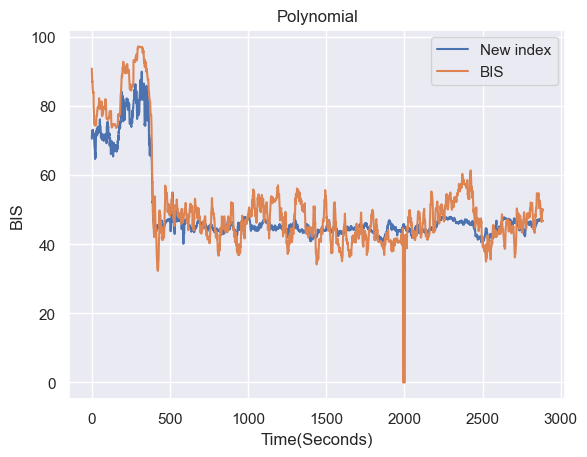

In [52]:
plt.plot(new_index_normalized, label='New index')
plt.plot(new_y,label ="BIS")
plt.title('Polynomial')
plt.ylabel('BIS')
plt.xlabel('Time(Seconds)')
plt.legend(loc="upper right")
plt.show()

KNN

In [53]:
# KNN

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Sample data for demonstration (replace this with your actual data)


# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(gud, new_y, test_size=0.2, random_state=42)

# Create a KNeighborsRegressor model
knn_regressor = KNeighborsRegressor()

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_neighbors': [3, 5, 7],  # Number of neighbors to use for prediction
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'p': [1, 2],  # Power parameter for the Minkowski distance (1 for Manhattan distance, 2 for Euclidean distance)
}

# Create a GridSearchCV object
grid_search = GridSearchCV(knn_regressor, param_grid, cv=5, scoring='neg_mean_squared_error')

# Perform the grid search to find the best hyperparameters
grid_search.fit(X_train, y_train)

# Get the best model with the best hyperparameters
best_knn_model = grid_search.best_estimator_

# Make predictions on the test set using the best model
y_pred = best_knn_model.predict(X_test)

# Model evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Best KNeighbors Regressor Model:", best_knn_model)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)


Best KNeighbors Regressor Model: KNeighborsRegressor(n_neighbors=7, p=1, weights='distance')
Mean Squared Error (MSE): 15.911000420282374
R-squared (R2): 0.9240665100516622


In [82]:
new_in = best_knn_model.predict(gud)

# Normalize the new index to the desired range (e.g., [0, 100]) using MinMaxScaler
scaler = MinMaxScaler(feature_range=(10, 90))
new_index_normalized = scaler.fit_transform(new_in.reshape(-1, 1)).flatten()

# Display the normalized new index for the first few data points
print("Normalized New Index:")
print(new_index_normalized[:5])

Normalized New Index:
[84.73792395 83.42240493 82.43576567 81.53134635 81.69578623]


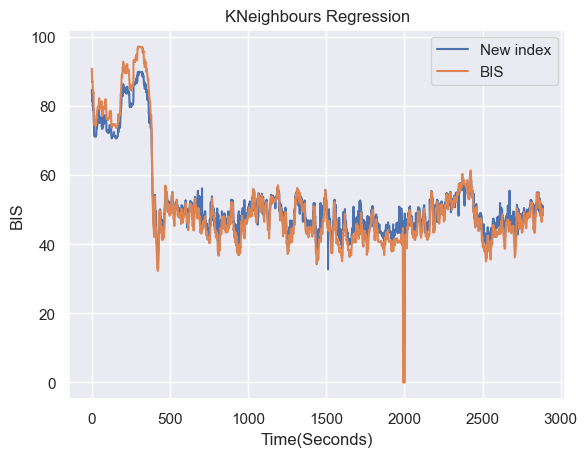

In [83]:
plt.plot(new_index_normalized, label='New index')
plt.plot(new_y,label ="BIS")
plt.title('KNeighbours Regression')
plt.ylabel('BIS')
plt.xlabel('Time(Seconds)')
plt.legend(loc="upper right")
plt.show()

In [98]:
# Support vecor regressor

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(gud, new_y, test_size=0.2, random_state=42)

# Create a SVR model
svr_regressor = SVR()

# Define the parameter grid for GridSearchCV
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Type of kernel function
    'C': [0.1, 1, 10, 20, 30],  # Regularization parameter (smaller values for stronger regularization)
    'epsilon': [0.1, 0.2, 0.3, 0.5, 0.6],  # Epsilon parameter in the epsilon-insensitive loss function
}

# Create a GridSearchCV object
grid_search = GridSearchCV(svr_regressor, param_grid, cv=5, scoring='neg_mean_squared_error')

# Perform the grid search to find the best hyperparameters
grid_search.fit(X_train, y_train)

# Get the best model with the best hyperparameters
best_svr_model = grid_search.best_estimator_

# Make predictions on the test set using the best model
y_pred = best_svr_model.predict(X_test)

# Model evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Best Support Vector Regressor Model:", best_svr_model)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)


Best Support Vector Regressor Model: SVR(C=30, kernel='linear')
Mean Squared Error (MSE): 61.24183668798999
R-squared (R2): 0.7077301069870311


In [80]:
new_index = best_svr_model.predict(gud)

# Normalize the new index to the desired range (e.g., [0, 100]) using MinMaxScaler
scaler = MinMaxScaler(feature_range=(40, 95))
new_index_normalized = scaler.fit_transform(new_index.reshape(-1, 1)).flatten()

# Display the normalized new index for the first few data points
print("Normalized New Index:")
print(new_index_normalized[:5])

Normalized New Index:
[87.55664051 87.24055517 88.25041252 87.67512327 88.64723011]


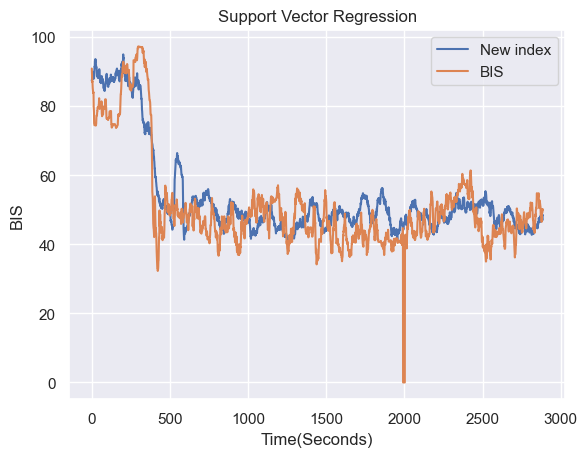

In [81]:
plt.plot(new_index_normalized, label='New index')
plt.plot(new_y,label ="BIS")
plt.title('Support Vector Regression')
plt.ylabel('BIS')
plt.xlabel('Time(Seconds)')
plt.legend(loc="upper right")
plt.show()

### Randomforest

In [76]:
# Randomforest

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Sample data for demonstration (replace this with your actual data)


# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(gud, new_y, test_size=0.2, random_state=42)

# Create a RandomForestRegressor model
rf_regressor = RandomForestRegressor(random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 5, 10, 20],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}

# Create a GridSearchCV object
grid_search = GridSearchCV(rf_regressor, param_grid, cv=5, scoring='neg_mean_squared_error')

# Perform the grid search to find the best hyperparameters
grid_search.fit(X_train, y_train)

# Get the best model with the best hyperparameters
best_rf_model = grid_search.best_estimator_

# Make predictions on the test set using the best model
y_pred = best_rf_model.predict(X_test)

# Model evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Best Random Forest Regressor Model:", best_rf_model)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)


Best Random Forest Regressor Model: RandomForestRegressor(max_depth=20, random_state=42)
Mean Squared Error (MSE): 17.690561798021598
R-squared (R2): 0.9155737501736122


In [77]:
new_ind = best_rf_model.predict(gud)

# Normalize the new index to the desired range (e.g., [0, 100]) using MinMaxScaler
scaler = MinMaxScaler(feature_range=(10, 90))
new_index_normalized = scaler.fit_transform(new_ind.reshape(-1, 1)).flatten()

# Display the normalized new index for the first few data points
print("Normalized New Index:")
print(new_index_normalized[:5])

Normalized New Index:
[79.80290748 80.4154346  80.40823898 79.14180992 79.30820863]


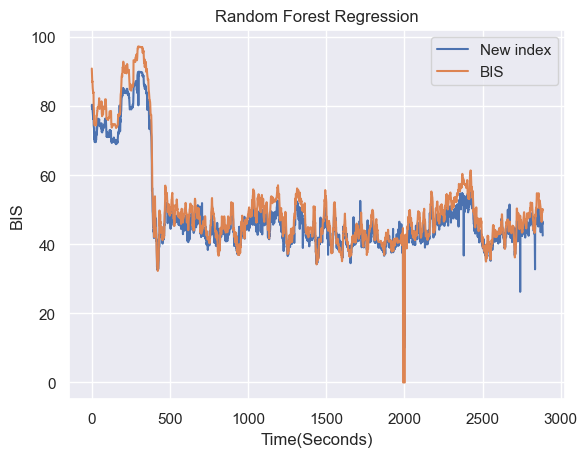

In [78]:
plt.plot(new_index_normalized, label='New index')
plt.plot(new_y,label ="BIS")
plt.title('Random Forest Regressor')
plt.ylabel('BIS')
plt.xlabel('Time(Seconds)')
plt.legend(loc="upper right")
plt.show()

In [91]:
gud=pd.DataFrame({'Perment_mode0_r2':resultsp_0, 'Perment_mode1_r2':resultsp_1, 'Perment_mode2_r2':resultsp_2, 'Perment_mode3_r2':resultsp_3, 'Perment_mode4_r2':resultsp_4,
                 'detf_mode0_r2':resultsdt_0, 'detf_mode1_r2':resultsdt_1, 'detf_mode2_r2':resultsdt_2, 'detf_mode3_r2':resultsdt_3, 'detf_mode4_r2':resultsdt_4,
  
                  'pet_mode0_r2':resultspet_0,'pet_mode1_r2':resultspet_1, 'pet_mode2_r2':resultspet_2, 'pet_mode3_r2':resultspet_3, 'pet_mode4_r2':resultspet_4,
                 'hm_mode0_r2':resultshm_0, 'hm_mode1_r2':resultshm_1, 'hm_mode2_r2':resultshm_2, 'hm_mode3_r2':resultshm_3, 'hm_mode4_r2':resultshm_4,
                 'hc_mode0_r2':resultshc_0, 'hc_mode1_r2':resultshc_1, 'hc_mode2_r2':resultshc_2, 'hc_mode3_r2':resultshc_3, 'hc_mode4_r2':resultshc_4,
                  'disp_mode0_r2':resultsd_0, 'disp_mode1_r2':resultsd_1, 'disp_mode2_r2':resultsd_2, 'disp_mode3_r2':resultsd_3, 'disp_mode4_r2':resultsd_4 
                 })


gud1=gud[['disp_mode4_r2', 'hm_mode3_r2', 'Perment_mode4_r2']]
new_y=df_hm['BIS']

### Polynomial

In [92]:
# ploynomial

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

# Sample data for demonstration (replace this with your actual data)


# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(gud1, new_y, test_size=0.2, random_state=42)

# Create a Pipeline for polynomial features and linear regression
pipeline = Pipeline([
    ('poly', PolynomialFeatures()),
    ('regressor', LinearRegression())
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'poly__degree': [2,4, 6],  # The degree of polynomial features
    'regressor__fit_intercept': [True, False],  # Whether to fit the intercept
    #'regressor__normalize': [True, False]  # Whether to normalize the features
}

# Create a GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring='neg_mean_squared_error')

# Perform the grid search to find the best hyperparameters
grid_search.fit(X_train, y_train)

# Get the best model with the best hyperparameters
best_model = grid_search.best_estimator_

# Make predictions on the test set using the best model
y_pred = best_model.predict(X_test)

# Model evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Best Model with Polynomial Features:", best_model)
print("Mean Squared Error (MSE) with Polynomial Features:", mse)
print("R-squared (R2) with Polynomial Features:", r2)


Best Model with Polynomial Features: Pipeline(steps=[('poly', PolynomialFeatures(degree=4)),
                ('regressor', LinearRegression(fit_intercept=False))])
Mean Squared Error (MSE) with Polynomial Features: 27.204223978513884
R-squared (R2) with Polynomial Features: 0.8701708495091502


In [93]:
new_in = best_model.predict(gud1)

# Normalize the new index to the desired range (e.g., [0, 100]) using MinMaxScaler
scaler = MinMaxScaler(feature_range=(40, 90))
new_index_normalized = scaler.fit_transform(new_in.reshape(-1, 1)).flatten()

# Display the normalized new index for the first few data points
print("Normalized New Index:")
print(new_index_normalized[:5])

Normalized New Index:
[70.5868235  71.8539431  72.50644743 72.96670163 72.47303155]


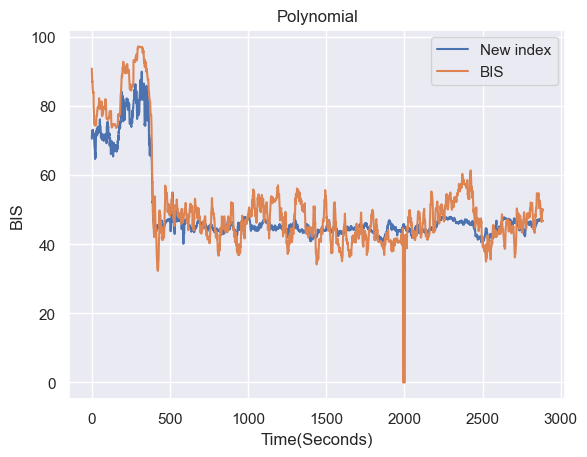

In [94]:
plt.plot(new_index_normalized, label='New index')
plt.plot(new_y,label ="BIS")
plt.title('Polynomial')
plt.ylabel('BIS')
plt.xlabel('Time(Seconds)')
plt.legend(loc="upper right")
plt.show()

### KNN

In [95]:
# KNN

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Sample data for demonstration (replace this with your actual data)


# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(gud1, new_y, test_size=0.2, random_state=42)

# Create a KNeighborsRegressor model
knn_regressor = KNeighborsRegressor()

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_neighbors': [3, 5, 7],  # Number of neighbors to use for prediction
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'p': [1, 2],  # Power parameter for the Minkowski distance (1 for Manhattan distance, 2 for Euclidean distance)
}

# Create a GridSearchCV object
grid_search = GridSearchCV(knn_regressor, param_grid, cv=5, scoring='neg_mean_squared_error')

# Perform the grid search to find the best hyperparameters
grid_search.fit(X_train, y_train)

# Get the best model with the best hyperparameters
best_knn_model = grid_search.best_estimator_

# Make predictions on the test set using the best model
y_pred = best_knn_model.predict(X_test)

# Model evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Best KNeighbors Regressor Model:", best_knn_model)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)


Best KNeighbors Regressor Model: KNeighborsRegressor(n_neighbors=7, p=1, weights='distance')
Mean Squared Error (MSE): 15.911000420282374
R-squared (R2): 0.9240665100516622


In [96]:
new_in = best_knn_model.predict(gud1)

# Normalize the new index to the desired range (e.g., [0, 100]) using MinMaxScaler
scaler = MinMaxScaler(feature_range=(10, 90))
new_index_normalized = scaler.fit_transform(new_in.reshape(-1, 1)).flatten()

# Display the normalized new index for the first few data points
print("Normalized New Index:")
print(new_index_normalized[:5])

Normalized New Index:
[84.73792395 83.42240493 82.43576567 81.53134635 81.69578623]


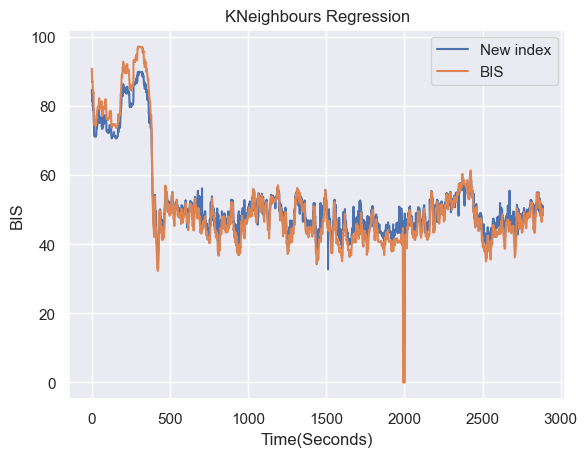

In [97]:
plt.plot(new_index_normalized, label='New index')
plt.plot(new_y,label ="BIS")
plt.title('KNeighbours Regression')
plt.ylabel('BIS')
plt.xlabel('Time(Seconds)')
plt.legend(loc="upper right")
plt.show()

### SVR

In [99]:
# Support vecor regressor

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(gud1, new_y, test_size=0.2, random_state=42)

# Create a SVR model
svr_regressor = SVR()

# Define the parameter grid for GridSearchCV
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Type of kernel function
    'C': [0.1, 1, 10, 20, 30],  # Regularization parameter (smaller values for stronger regularization)
    'epsilon': [0.1, 0.2, 0.3, 0.5, 0.6],  # Epsilon parameter in the epsilon-insensitive loss function
}

# Create a GridSearchCV object
grid_search = GridSearchCV(svr_regressor, param_grid, cv=5, scoring='neg_mean_squared_error')

# Perform the grid search to find the best hyperparameters
grid_search.fit(X_train, y_train)

# Get the best model with the best hyperparameters
best_svr_model = grid_search.best_estimator_

# Make predictions on the test set using the best model
y_pred = best_svr_model.predict(X_test)

# Model evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Best Support Vector Regressor Model:", best_svr_model)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)


Best Support Vector Regressor Model: SVR(C=30, epsilon=0.6, kernel='poly')
Mean Squared Error (MSE): 59.79097744426942
R-squared (R2): 0.7146541722808182


In [100]:
new_index = best_svr_model.predict(gud1)

# Normalize the new index to the desired range (e.g., [0, 100]) using MinMaxScaler
scaler = MinMaxScaler(feature_range=(40, 95))
new_index_normalized = scaler.fit_transform(new_index.reshape(-1, 1)).flatten()

# Display the normalized new index for the first few data points
print("Normalized New Index:")
print(new_index_normalized[:5])

Normalized New Index:
[87.55664051 87.24055517 88.25041252 87.67512327 88.64723011]


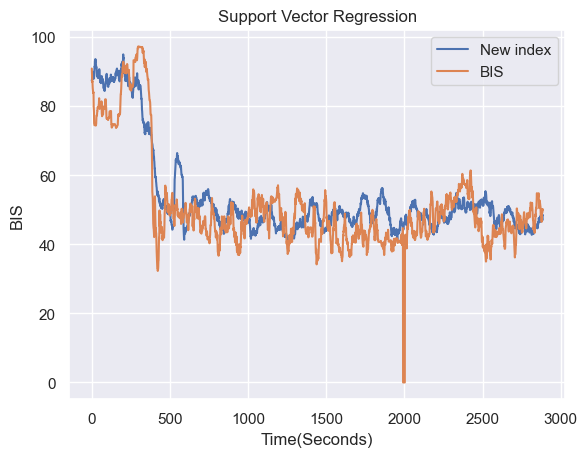

In [101]:
plt.plot(new_index_normalized, label='New index')
plt.plot(new_y,label ="BIS")
plt.title('Support Vector Regression')
plt.ylabel('BIS')
plt.xlabel('Time(Seconds)')
plt.legend(loc="upper right")
plt.show()

### Random forest regressor

In [102]:
# Randomforest

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Sample data for demonstration (replace this with your actual data)


# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(gud1, new_y, test_size=0.2, random_state=42)

# Create a RandomForestRegressor model
rf_regressor = RandomForestRegressor(random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 5, 10, 20],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}

# Create a GridSearchCV object
grid_search = GridSearchCV(rf_regressor, param_grid, cv=5, scoring='neg_mean_squared_error')

# Perform the grid search to find the best hyperparameters
grid_search.fit(X_train, y_train)

# Get the best model with the best hyperparameters
best_rf_model = grid_search.best_estimator_

# Make predictions on the test set using the best model
y_pred = best_rf_model.predict(X_test)

# Model evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Best Random Forest Regressor Model:", best_rf_model)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)


Best Random Forest Regressor Model: RandomForestRegressor(max_depth=20, random_state=42)
Mean Squared Error (MSE): 17.690561798021598
R-squared (R2): 0.9155737501736122


In [103]:
new_ind = best_rf_model.predict(gud1)

# Normalize the new index to the desired range (e.g., [0, 100]) using MinMaxScaler
scaler = MinMaxScaler(feature_range=(10, 90))
new_index_normalized = scaler.fit_transform(new_ind.reshape(-1, 1)).flatten()

# Display the normalized new index for the first few data points
print("Normalized New Index:")
print(new_index_normalized[:5])

Normalized New Index:
[79.80290748 80.4154346  80.40823898 79.14180992 79.30820863]


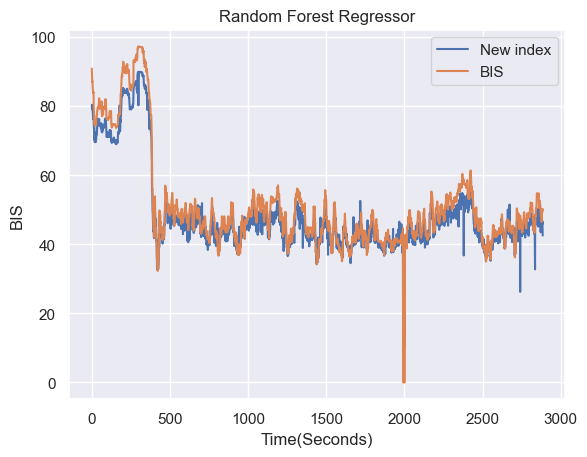

In [104]:
plt.plot(new_index_normalized, label='New index')
plt.plot(new_y,label ="BIS")
plt.title('Random Forest Regressor')
plt.ylabel('BIS')
plt.xlabel('Time(Seconds)')
plt.legend(loc="upper right")
plt.show()